# Mining Unexpected Concepts
---

**Libraries**

In [42]:
from collections import defaultdict
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.data import load_netset, from_edge_list
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques
from sknetwork.visualization import svg_graph

## Data

In [43]:
# Load dataset
with open('data/baboons', 'br') as f:
    dataset = pickle.load(f)
    
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
names_col = dataset.names_col

In [44]:
names

array(['ANGELE', 'ARIELLE', 'ATMOSPHERE', 'BOBO', 'EWINE', 'FANA',
       'FELIPE', 'FEYA', 'HARLEM', 'KALI', 'LIPS', 'LOME', 'MAKO', 'MALI',
       'MUSE', 'NEKKE', 'PETOULETTE', 'PIPO', 'VIOLETTE'], dtype='<U10')

In [45]:
names_col

array(['Touching', 'Submission', 'Grooming', 'Supplanting', 'Threatening',
       'Grunting-Lipsmacking', 'Carrying', 'Invisible', 'Presenting',
       'Avoiding', 'Playing with', 'Other', 'Resting', 'Attacking'],
      dtype='<U20')

## Algorithm

In [46]:
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    return (nodes_mdl + edges_mdl)

def build_random_graph(n, p):
    edges = []
    lp = np.log(1 - p)
    v = 1
    w = -1
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((w, v))
    
    v = 1
    w = -1   
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((v, w))
    try:
        g = from_edge_list(edges, directed=True, matrix_only=True)
    except ValueError:
        return None

    return g

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

In [173]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, depth, degs, gain, verbose):
    
    support_obj = 3
    support_attr = 10
    delta = 0.5
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)
          
        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        if new_extent_size >= support_obj:
            if verbose:
                print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                print(f'  Candidate attr: {j} {sorted_names_col[j]}')
                print(f'  new extent: {new_extent}')
                
            #if new_extent_size < len(extents[r]):
            # Graph unexpectedness
            g_r_new = adjacency[new_extent][:, new_extent]
            complexity_desc_g = mdl_graph(g_r_new)
            complexity_gen_g = np.max(complexity_gen_graphs.get(new_extent_size))
            unex_g = complexity_gen_g - complexity_desc_g
            unexs_g.append(unex_g)
            if verbose:
                print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')
            
            new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
            new_intent_size = len(new_intent)            
                
            if new_intent_size <= support_attr:
            
                # Attributes unexpectedness
                complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                complexity_desc_a = 0
                for a in new_intent:
                    complexity_desc_a += np.log2(degs[a])
                unex_a = complexity_gen_a - complexity_desc_a
                if verbose:
                    print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                # Total Unexpectedness
                unex = unex_g + unex_a
                if verbose:
                    print(f'  U: {unex}')
                unexs[r_new] = unex

                if verbose:
                    print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                gain_unex.append(unex - unexs[r])
                if verbose:
                    print(f'  gain unex: {gain_unex}')
                    print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')
                    
                if new_extent_size == len(extents[r]):
                    
                    #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                    if (unex - unexs[r] > 0) and r >=0 and (gain_unex[-2] - gain_unex[-1]) > delta:
                        intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        extents[r] = extents[r_new]
                        unexs_g[r] = unex_g
                        unexs[r] = unex
                        if verbose:
                            print(f'  Attribute {j}-{sorted_names_col[j]} added')
                    else:
                        if verbose:
                            print(f'  r_new: {r_new} - r: {r}')
                            print(f'  gain_unex[(r_new-r):]: {gain_unex[(r_new - r):]}')
                            print(f'   gain_unex[-len(intents[r])+1]= {gain_unex[-len(intents[r])+1]} - {len(intents[r])+1}')
                            print(f'  --> Stop branch recursion because unexpectedness gain is too low abs({(gain_unex[-2])}-{gain_unex[-1]})={np.abs(gain_unex[-2]-gain_unex[-1])}')
                            print('\n')
                        
                        del gain_unex[(r_new-r):]
                        #del gain_unex[(len(intents[r]+1)):]
                        return [*zip(extents, intents)]

                else:
                    print(f'{unex-unexs[r]} - {r} - {gain_unex[-2]} {gain_unex[-1]}')
                    #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                    if (unex - unexs[r] > 0):

                        try:
                            intents[r_new] = []
                        except IndexError:
                            intents.append([])

                        intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        if verbose:
                            print('  recursive call')
                        in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, depth=5, degs=degs, gain=gain_unex, verbose=verbose)
                    else:
                        if verbose:
                            print(f'  Stop recursion.')
                            print()
                        gain_unex.pop(-1)
            else:
                if verbose:
                    print(f'Max number of attributes reached.')
                    print('\n')
                return [*zip(extents, intents)]

    if verbose:
        print('\n')
    del gain_unex[-(len(intents[r])+1):]
    
    return [*zip(extents, intents)]

## Application

### Minimum Description Lengths of random graphs  

Build a dictionary of MDL for random graphs with varying number of nodes and density.

In [107]:
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[3:100]:
    for j in range(30):
        for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            random_g = build_random_graph(num_n, p)
            if random_g is not None:
                mdl = mdl_graph(random_g)
                complexity_gen_graphs[num_n].append(mdl)

In [174]:
# In-close initialization
V = np.arange(0, biadjacency.shape[0])
extents, intents, unexs, unexs_g = [], [], [], []
extents_init = V
intents_init = []
unexs.append(0)
unexs_g.append(0)
extents.append(extents_init)
intents.append(intents_init)

In [175]:
%%time

global r_new
r_new = 0
global gain_unex
gain_unex = []
gain_unex.append(0)

# Degree of attribute = # articles in which it appears
degrees = get_degrees(biadjacency.astype(bool), transpose=True)

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
indexes = np.argsort(degrees)
sorted_degs = degrees[indexes]
filt_biadjacency = biadjacency[:, indexes]
sorted_names_col = names_col[indexes]

with open('logs/log_baboon.txt', 'w') as f:
    with redirect_stdout(f):
        result = in_close(adjacency, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, depth=5, degs=sorted_degs, gain=gain_unex, verbose=True)
        print()

TypeError: can only concatenate list (not "int") to list

In [172]:
for r in result:
    print(r[1])

[]
[4]
[5]
[6]
[ 6 10]
[7]
[8]
[9]
[10]
[11]
[12]


Supplanting


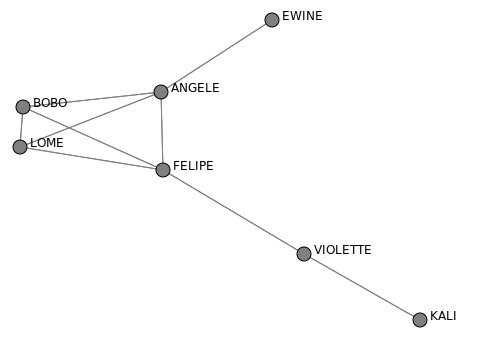

In [154]:
# First graph
objs = np.array([0, 3, 4, 6, 9, 11, 18])
attrs = 6
print(sorted_names_col[attrs])
image = svg_graph(adjacency[objs, :][:, objs], names=names[objs])
SVG(image)

['Supplanting' 'Invisible']


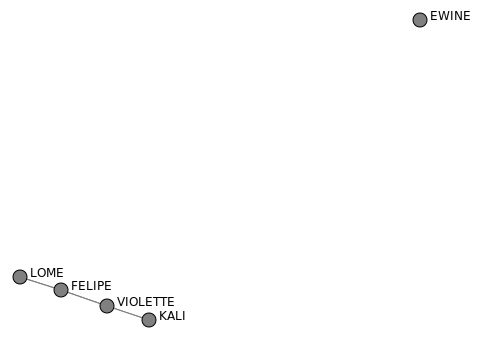

In [156]:
# First graph
objs = np.array([4, 6, 9, 11, 18])
attrs = np.array([6, 10])
print(sorted_names_col[attrs])
image = svg_graph(adjacency[objs, :][:, objs], names=names[objs])
SVG(image)

In [157]:
result

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18], dtype=int32),
  array([13])),
 (array([11, 18, 10, 13], dtype=int32), array([4])),
 (array([ 1,  3,  6,  9, 16, 17], dtype=int32), array([5])),
 (array([ 0,  3,  4,  6,  9, 11, 18], dtype=int32), array([6])),
 (array([ 3,  5,  6,  7, 16, 17, 18], dtype=int32), array([7])),
 (array([ 5,  6,  7, 10, 13, 15, 16, 17], dtype=int32), array([8])),
 (array([ 2,  6,  7, 10, 11, 12, 13, 14, 15], dtype=int32), array([9])),
 (array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 17, 18],
        dtype=int32),
  array([10])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
         18], dtype=int32),
  array([12]))]